In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
def process_string(string):
    string = re.sub('[^A-Za-z0-9\-\/ ]+', ' ', string).split()
    return [y.strip() for y in string]

In [3]:
def parse_raw(filename):
    with open(filename, 'r') as fopen:
        entities = fopen.read()
    soup = BeautifulSoup(entities, 'html.parser')
    inside_tag = ''
    texts, labels = [], []
    for sentence in soup.prettify().split('\n'):
        if len(inside_tag):
            splitted = process_string(sentence)
            texts += splitted
            labels += [inside_tag] * len(splitted)
            inside_tag = ''
        else:
            if not sentence.find('</'):
                pass
            elif not sentence.find('<'):
                inside_tag = sentence.split('>')[0][1:]
            else:
                splitted = process_string(sentence)
                texts += splitted
                labels += ['OTHER'] * len(splitted)
    assert (len(texts)==len(labels)), "length texts and labels are not same"
    print('len texts and labels: ', len(texts))
    return texts,labels

In [4]:
train_texts, train_labels = parse_raw('data_train.txt')
test_texts, test_labels = parse_raw('data_test.txt')
train_texts += test_texts
train_labels += test_labels

len texts and labels:  34012
len texts and labels:  9249


In [5]:
np.unique(train_labels,return_counts=True)

(array(['OTHER', 'location', 'organization', 'person', 'quantity', 'time'],
       dtype='<U12'), array([35613,  1536,  1592,  2358,  1336,   826]))

In [6]:
with open('entities-bm-normalize-v3.txt','r') as fopen:
    entities_bm = fopen.read().split('\n')[:-1]
entities_bm = [i.split() for i in entities_bm]
entities_bm = [[i[0],'TIME' if i[0] in 'jam' else i[1]] for i in entities_bm]

In [7]:
replace_by = {'LOC':'location','PRN':'person','NORP':'organization','ORG':'organization','LAW':'law',
             'EVENT':'OTHER','FAC':'organization','TIME':'time','O':'OTHER','ART':'person','DOC':'law'}
for i in entities_bm:
    try:
        string = process_string(i[0])
        if len(string):
            train_labels.append(replace_by[i[1]])
            train_texts.append(process_string(i[0])[0])  
    except Exception as e:
        print(e)
        
assert (len(train_texts)==len(train_labels)), "length texts and labels are not same"

'KN'
'KA'


In [8]:
np.unique(train_labels,return_counts=True)

(array(['OTHER', 'law', 'location', 'organization', 'person', 'quantity',
        'time'], dtype='<U12'),
 array([47406,   107,  2010,  2435,  3913,  1336,  1240]))

In [9]:
word2idx = {'PAD': 0,'NUM':1,'UNK':2}
tag2idx = {'PAD': 0}
char2idx = {'PAD': 0}
word_idx = 3
tag_idx = 1
char_idx = 1

def parse_XY(texts, labels):
    global word2idx, tag2idx, char2idx, word_idx, tag_idx, char_idx
    X, Y = [], []
    for no, text in enumerate(texts):
        text = text.lower()
        tag = labels[no]
        for c in text:
            if c not in char2idx:
                char2idx[c] = char_idx
                char_idx += 1
        if tag not in tag2idx:
            tag2idx[tag] = tag_idx
            tag_idx += 1
        Y.append(tag2idx[tag])
        if text not in word2idx:
            word2idx[text] = word_idx
            word_idx += 1
        X.append(word2idx[text])
    return X, np.array(Y)

In [10]:
np.unique(train_labels)

array(['OTHER', 'law', 'location', 'organization', 'person', 'quantity',
       'time'], dtype='<U12')

In [11]:
X, Y = parse_XY(train_texts, train_labels)
idx2word={idx: tag for tag, idx in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [12]:
seq_len = 50
def iter_seq(x):
    return np.array([x[i: i+seq_len] for i in range(0, len(x)-seq_len, 1)])

def to_train_seq(*args):
    return [iter_seq(x) for x in args]

def generate_char_seq(batch):
    x = [[len(idx2word[i]) for i in k] for k in batch]
    maxlen = max([j for i in x for j in i])
    temp = np.zeros((batch.shape[0],batch.shape[1],maxlen),dtype=np.int32)
    for i in range(batch.shape[0]):
        for k in range(batch.shape[1]):
            for no, c in enumerate(idx2word[batch[i,k]]):
                temp[i,k,-1-no] = char2idx[c]
    return temp

In [13]:
import json
with open('crf-lstm-concat-bidirectional.json','w') as fopen:
    fopen.write(json.dumps({'idx2tag':idx2tag,'idx2word':idx2word,
           'word2idx':word2idx,'tag2idx':tag2idx,'char2idx':char2idx}))

In [14]:
X_seq, Y_seq = to_train_seq(X, Y)
X_char_seq = generate_char_seq(X_seq)
X_seq.shape

(58397, 50)

In [15]:
from keras.utils import to_categorical
Y_seq_3d = [to_categorical(i, num_classes=len(tag2idx)) for i in Y_seq]

Using TensorFlow backend.


In [16]:
from sklearn.cross_validation import train_test_split
train_X, test_X, train_Y, test_Y, train_char, test_char = train_test_split(X_seq, Y_seq_3d, X_char_seq, 
                                                                           test_size=0.1)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
import keras
print(keras.__version__)

2.2.2


In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Reshape, Concatenate, Lambda
from keras_contrib.layers import CRF
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
set_session(tf.InteractiveSession())

In [19]:
max_len = seq_len
input_word = Input(shape=(None,))
input_char = Input(shape=(None,None,))
model_char = Embedding(input_dim=len(char2idx) + 1, output_dim=128)(input_char)
s = K.shape(model_char)
def backend_reshape(x):
    return K.reshape(x, (s[0]*s[1],s[2],128))
model_char = Lambda(backend_reshape)(model_char)
model_char = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model_char)
def sliced(x):
    return x[:,-1]
model_char = Lambda(sliced)(model_char)
def backend_reshape(x):
    return K.reshape(x, (s[0],s[1],100))
model_char = Lambda(backend_reshape)(model_char)
model_word = Embedding(input_dim=len(word2idx) + 1, output_dim=64, mask_zero=True)(input_word)
concated_word_char = Concatenate(-1)([model_char,model_word])
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(concated_word_char)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(len(tag2idx))
output = crf(model)

In [20]:
model = Model(inputs=[input_word, input_char], outputs=output)

In [21]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None)   0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, None, 1 5120        input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 128)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 100)    71600       lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (

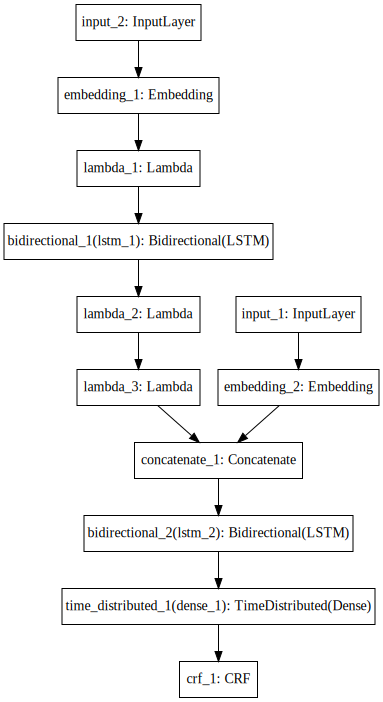

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [24]:
history = model.fit([train_X,train_char], np.array(train_Y), batch_size=32, epochs=3,
                    validation_split=0.1, verbose=1)

Train on 47301 samples, validate on 5256 samples
Epoch 1/3
47301/47301 [==============================] - 521s 11ms/step - loss: 0.1176 - acc: 0.9619 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 2/3
47301/47301 [==============================] - 524s 11ms/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.0054 - val_acc: 0.9980
Epoch 3/3
47301/47301 [==============================] - 520s 11ms/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0027 - val_acc: 0.9991


In [25]:
predicted=model.predict([test_X,test_char],verbose=1)

5840/5840 [==============================] - 20s 3ms/step


In [26]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
    
pred_labels = pred2label(predicted)
test_labels = pred2label(test_Y)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_labels).ravel(), np.array(pred_labels).ravel()))

              precision    recall  f1-score   support

       OTHER       1.00      1.00      1.00    236000
         law       1.00      0.99      1.00       472
    location       1.00      1.00      1.00     10303
organization       1.00      1.00      1.00     12525
      person       1.00      1.00      1.00     19828
    quantity       1.00      1.00      1.00      6599
        time       1.00      1.00      1.00      6273

 avg / total       1.00      1.00      1.00    292000



In [28]:
model.save_weights('crf-lstm-concat-bidirectional.h5')